In [58]:
# Librerie
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from FisherDA import MultipleFisherDiscriminantAnalysis as MDA

In [59]:
# Imposto uno stile per i grafici
sns.set(style="whitegrid")

# Leggo i dati (PERFETTO per la tua struttura)
df_red = pd.read_csv('../data/winequality-red.csv', sep=';')
df_white = pd.read_csv('../data/winequality-white.csv', sep=';')

df_red.info()

# Info sui dati
print("Red wine shape:", df_red.shape)
#print("White wine shape:", df_white.shape)

# Opzione per vedere tutte le colonne (evita i "...")
pd.set_option('display.max_columns', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Red wine shape: (1599, 12)


In [60]:
# Prime righe
df_red.head()

# Funzione per visualizzare una parte del DataFrame
def mostra(df, righe=5, titolo="Anteprima del DataFrame"):
    styled = (
        df.head(righe)
          .style.set_caption(titolo)
          .background_gradient(cmap='Blues')
          .set_table_styles([
              {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
              {'selector': 'td', 'props': [('font-size', '11pt')]}
          ])
    )
    display(styled)
    
# Versione per gli ultimi dati
def mostra_righe(df, righe=5, titolo="Ultime righe del DataFrame"):
    styled = (
        df.tail(righe)
          .style.set_caption(titolo)
          .format(precision=2)
          .background_gradient(cmap='Oranges')
    )
    display(styled)

mostra_righe(df_red.head(), 5, "Prime 5 righe del dataset - Vino Rosso")
#mostra(df_white, 5, "Prime 10 righe del dataset - Vino Bianco")

mostra_righe(df_red.tail(), 5, "Ultime 5 righe - Vino Rosso")


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.20,0.60,0.08,2.00,0.09,32.00,44.00,0.99,3.45,0.58,10.50,5
1595,5.90,0.55,0.10,2.20,0.06,39.00,51.00,1.00,3.52,0.76,11.20,6
1596,6.30,0.51,0.13,2.30,0.08,29.00,40.00,1.00,3.42,0.75,11.00,6
1597,5.90,0.65,0.12,2.00,0.07,32.00,44.00,1.00,3.57,0.71,10.20,5
1598,6.00,0.31,0.47,3.60,0.07,18.00,42.00,1.00,3.39,0.66,11.00,6


In [61]:
#Conteggio qualità
df_quality = df_red['quality'].value_counts().sort_index().to_frame(name='Numero di vini')
df_quality.index.name = 'Qualità'
mostra(df_quality, righe=len(df_quality), titolo="Distribuzione dei vini per qualità")

,Numero di vini
Qualità,
3,10
4,53
5,681
6,638
7,199
8,18


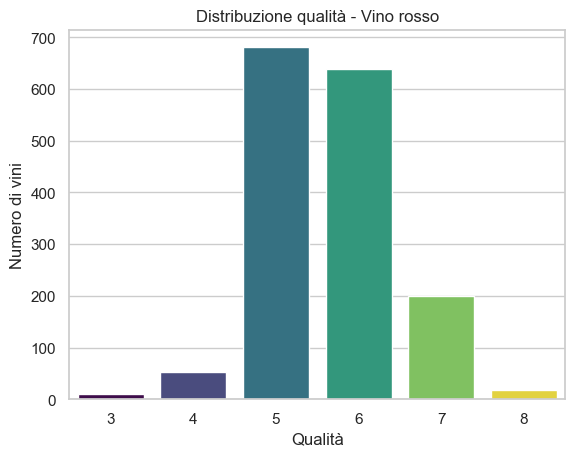

In [62]:
# Statistiche descrittive
df_red.describe()

# Check null
df_red.isnull().sum()

# 1 - Distribuzione qualità (conteggio)
sns.countplot(x='quality', data=df_red, hue='quality', palette='viridis', legend=False)
plt.title("Distribuzione qualità - Vino rosso")
plt.xlabel("Qualità")
plt.ylabel("Numero di vini")
plt.show()

def qualità_in_classi(q):
    if q <= 5:
        return 0
    else:
        return 1

df_red['quality_class'] = df_red['quality'].apply(qualità_in_classi)

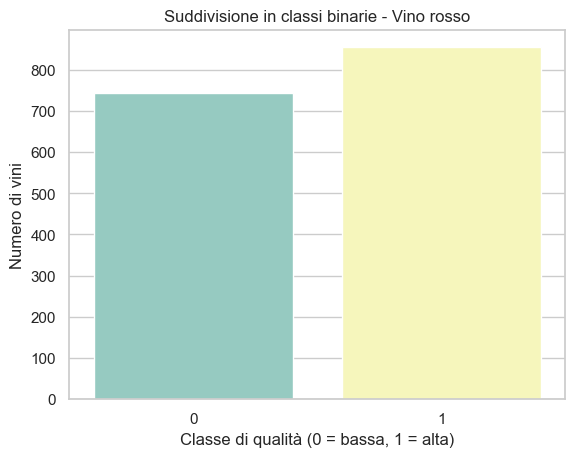

In [63]:
# 2 – Distribuzione classi binarie
sns.countplot(x='quality_class', data=df_red, hue='quality_class', palette='Set3', legend=False)
plt.title("Suddivisione in classi binarie - Vino rosso")
plt.xlabel("Classe di qualità (0 = bassa, 1 = alta)")
plt.ylabel("Numero di vini")
plt.show()

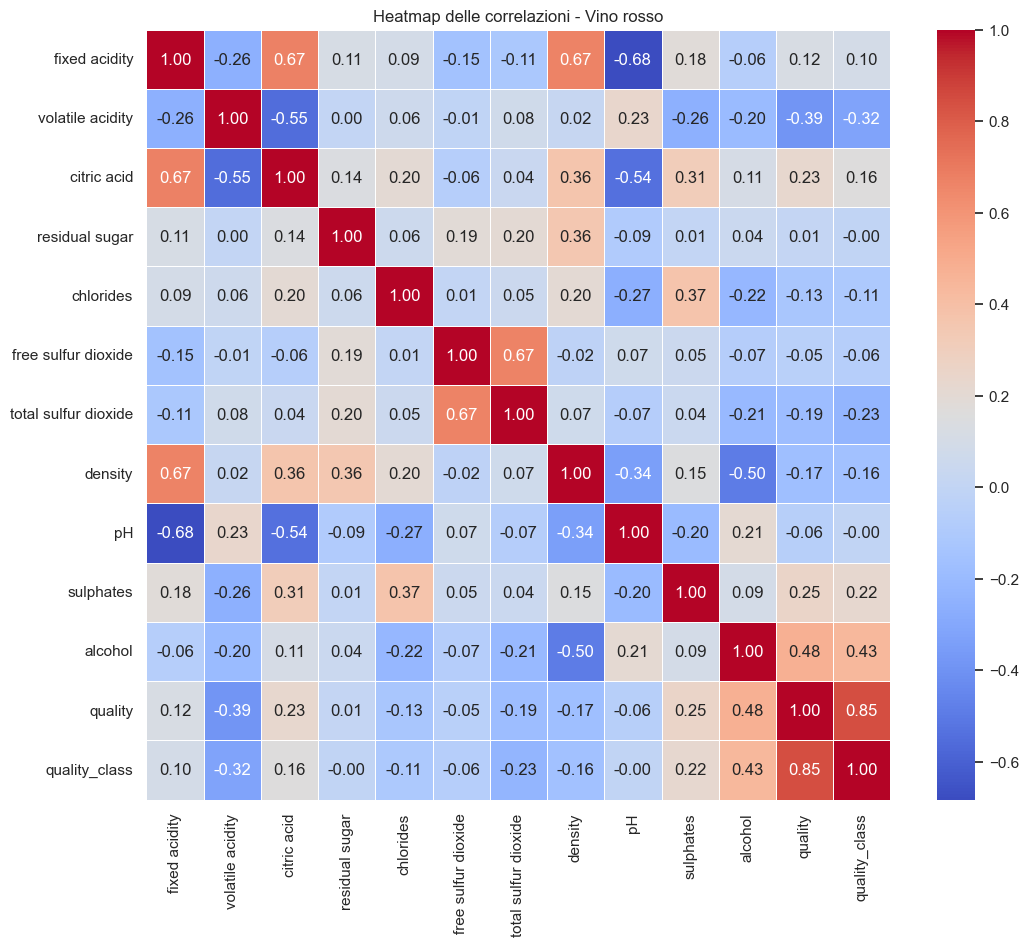

In [64]:
# Correlazioni tra variabili
plt.figure(figsize=(12,10))
sns.heatmap(df_red.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap delle correlazioni - Vino rosso")
plt.show()

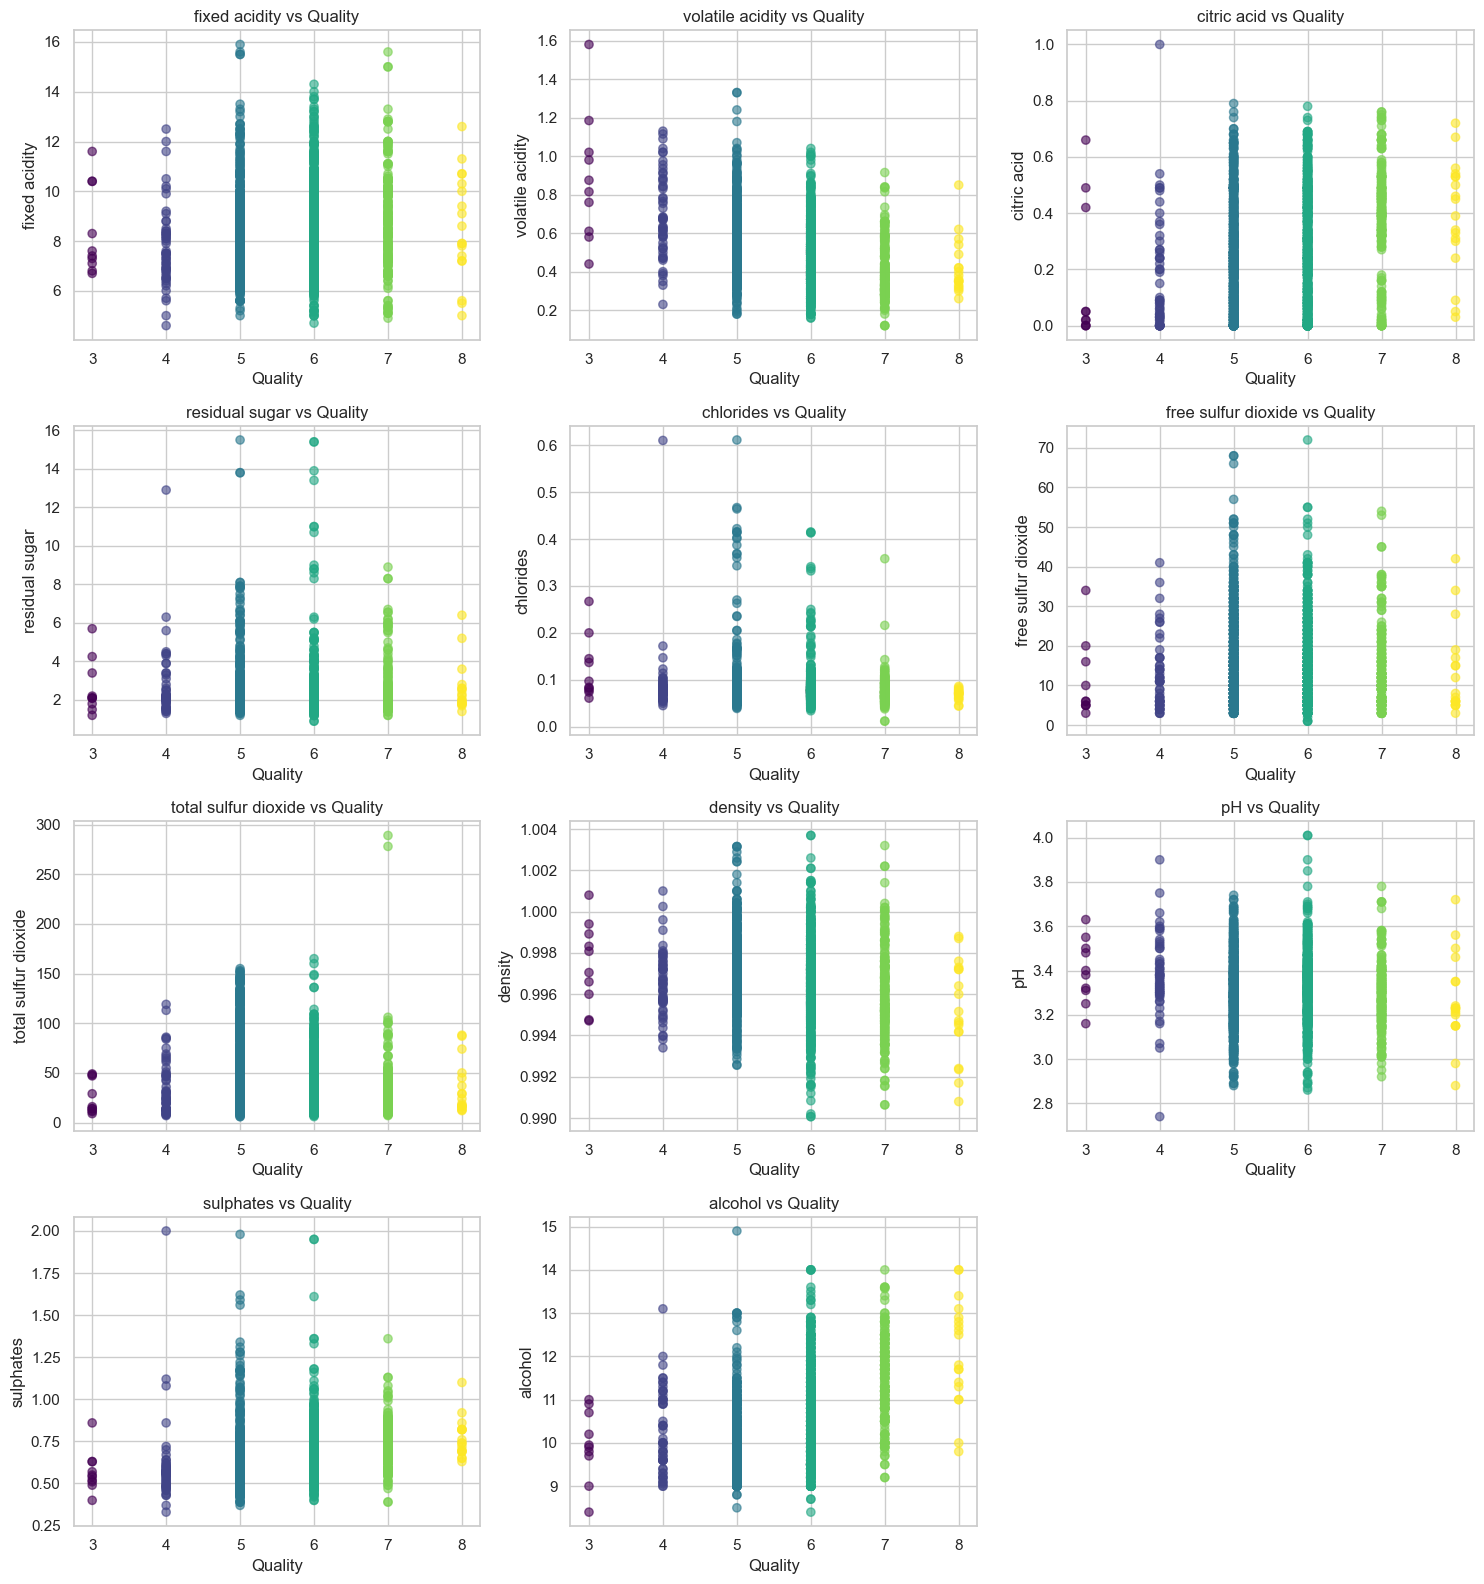

In [65]:
# Prendiamo solo le colonne numeriche
features = df_red.select_dtypes(include='number').columns.drop(['quality_class','quality'])

# Creiamo i sottoplot
n = len(features)
cols = 3
rows = (n // cols) + (n % cols > 0)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(df_red['quality'], df_red[col], c=df_red['quality'], cmap='viridis', alpha=0.6)
    plt.title(f"{col} vs Quality")
    plt.xlabel("Quality")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [66]:
# 1. Seleziona X e y
X = df_red.drop(columns=['quality', 'quality_class'])
y = df_red['quality_class']  # o 'quality' se preferisci

# 2. Dividi in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Applica trasformazioni SOLO al training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



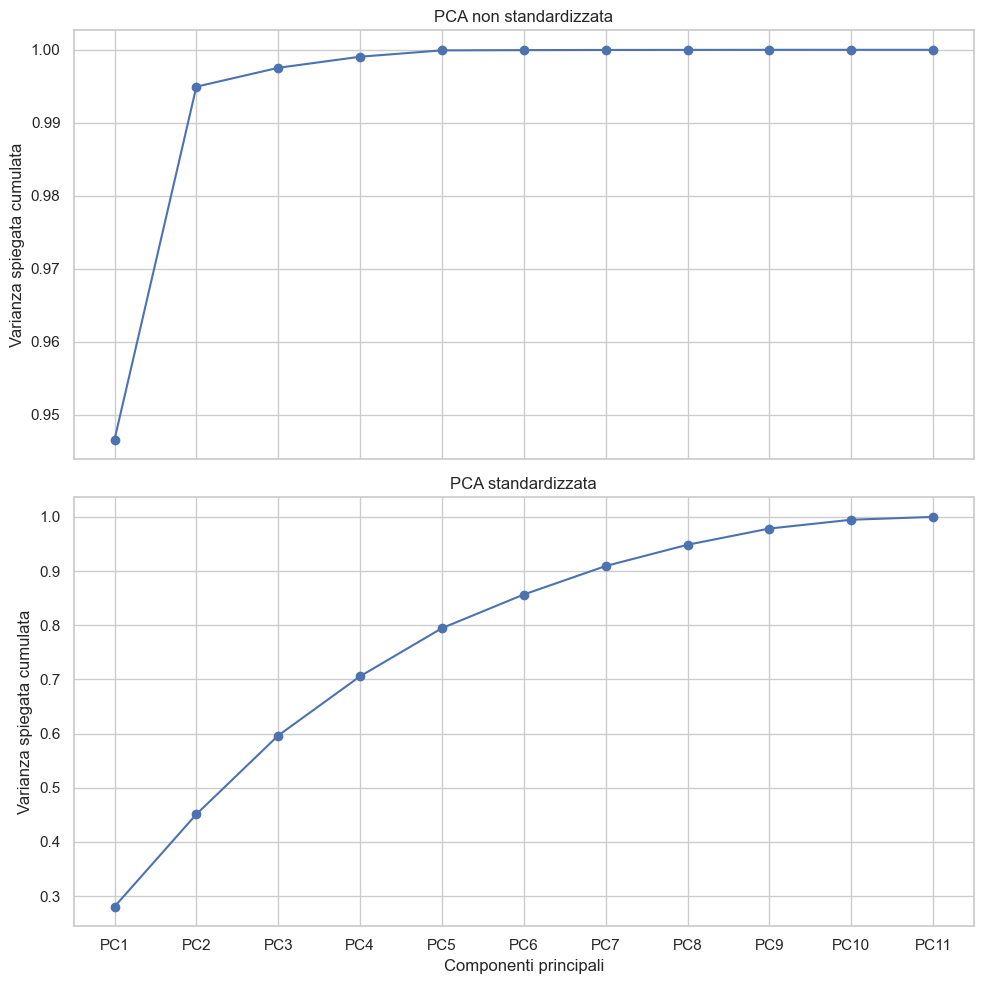

In [67]:
# PCA NON standardizzata
pca = PCA()
pca.fit(X)

# 4. PCA STANDARDIZZATA
pca_std = PCA()
X_train_pca = pca_std.fit_transform(X_train_scaled)
X_test_pca = pca_std.transform(X_test_scaled)

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
cumulative_var_std = np.cumsum(pca_std.explained_variance_ratio_)

# Etichette delle componenti (PC1, PC2, ...)
component_labels = [f"PC{i+1}" for i in range(X_train.shape[1])]

# Plot doppio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Grafico 1: senza standardizzazione
axs[0].plot(component_labels, cumulative_var, marker='o')
axs[0].set_title("PCA non standardizzata")
axs[0].set_ylabel("Varianza spiegata cumulata")
axs[0].grid(True)

# Grafico 2: con standardizzazione
axs[1].plot(component_labels, cumulative_var_std, marker='o')
axs[1].set_title("PCA standardizzata")
axs[1].set_xlabel("Componenti principali")
axs[1].set_ylabel("Varianza spiegata cumulata")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [68]:
# 1. Selezione delle feature numeriche
features = df_red.select_dtypes(include='number').drop(columns=['quality', 'quality_class'])

# 2. Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. PCA con tutte le componenti
pca_full = PCA()
pca_full.fit(X_scaled)

# 4. Calcolo della varianza cumulativa
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

# 5. Trovo quante componenti servono per spiegare almeno il 97% della varianza
n_components_97 = np.argmax(cumulative_var >= 0.97) + 1  # +1 perché gli indici partono da 0

# 6. Riepilogo in DataFrame
df_pca = pd.DataFrame({
    'val': [n_components_97, cumulative_var[n_components_97 - 1]]
}, index=['n. PC', 'expl. Var. (%)'])

# 7. Visualizzazione
display(df_pca)

,val
n. PC,9.000000
expl. Var. (%),0.978101


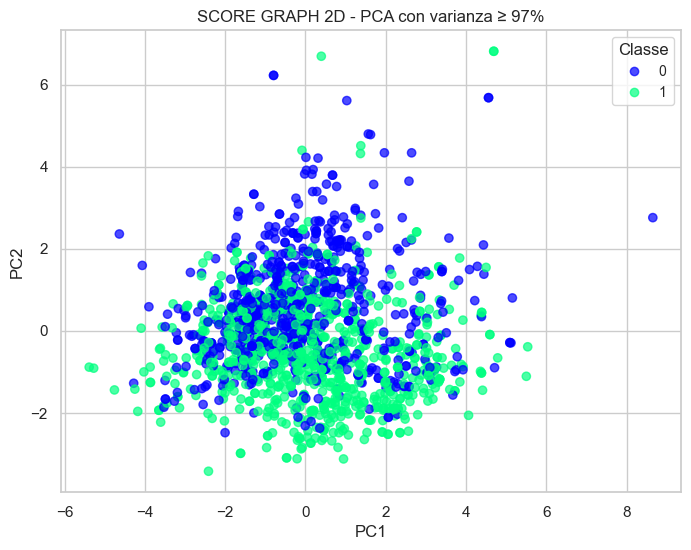

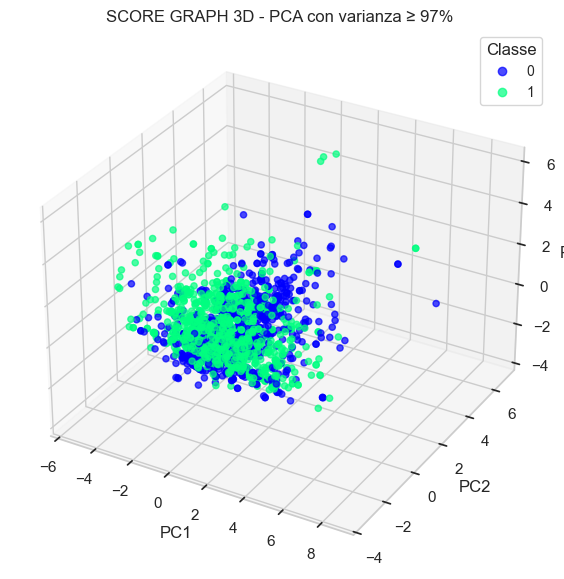

Varianza totale spiegata dalle componenti: 0.9781


In [69]:
# Selezione delle feature numeriche
features = df_red.select_dtypes(include='number').drop(columns=['quality', 'quality_class'])

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA per spiegare almeno il 97% della varianza
pca = PCA(0.97)
pca.fit(X_scaled)

# Proiezione nello spazio ridotto
Y_pca = pca.transform(X_scaled)

# Etichette della classe (usate per colorare i punti)
targets = df_red['quality_class']
class_labels = sorted(targets.unique())

# SCORE GRAPH 2D

plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=targets.astype('category').cat.codes, cmap='winter', alpha=0.7)
plt.title('SCORE GRAPH 2D - PCA con varianza ≥ 97%')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# Aggiunta legenda
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, title='Classe', fontsize='small')
plt.show()

# SCORE GRAPH 3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(Y_pca[:, 0], Y_pca[:, 1], Y_pca[:, 2],
                     c=targets.astype('category').cat.codes, cmap='winter', alpha=0.7)

ax.set_title('SCORE GRAPH 3D - PCA con varianza ≥ 97%')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.grid(True)

# Aggiunta legenda
plt.legend(handles=scatter.legend_elements()[0], labels=class_labels, title='Classe', fontsize='small')
plt.show()

# Varianza spiegata

print(f'Varianza totale spiegata dalle componenti: {pca.explained_variance_ratio_.sum():.4f}')


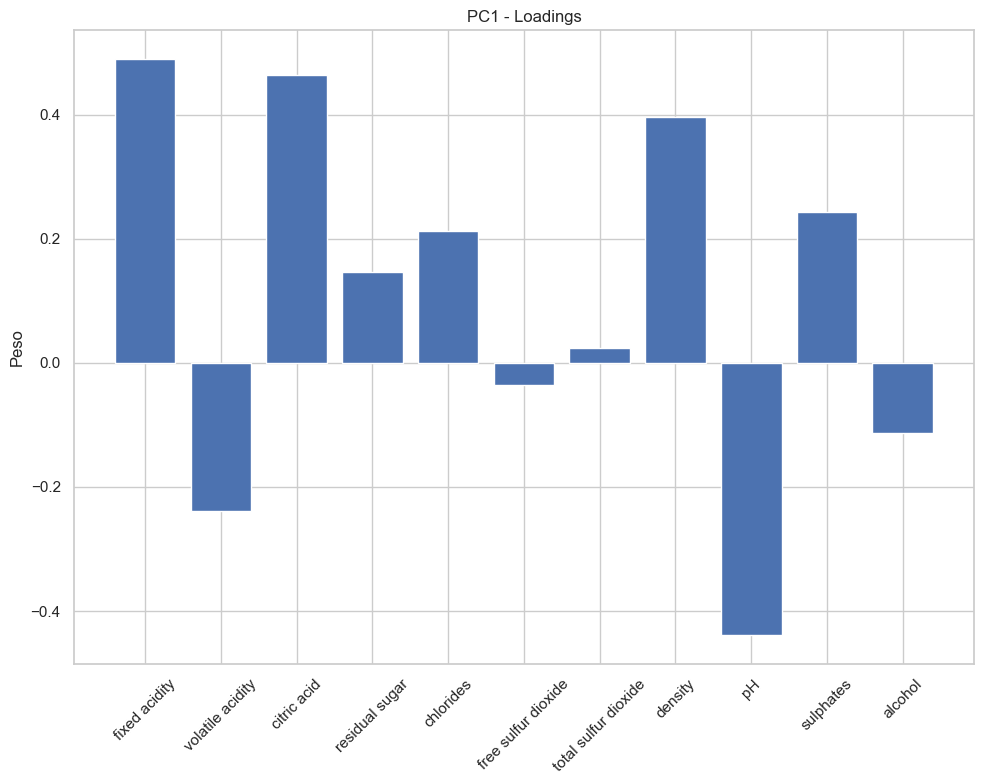

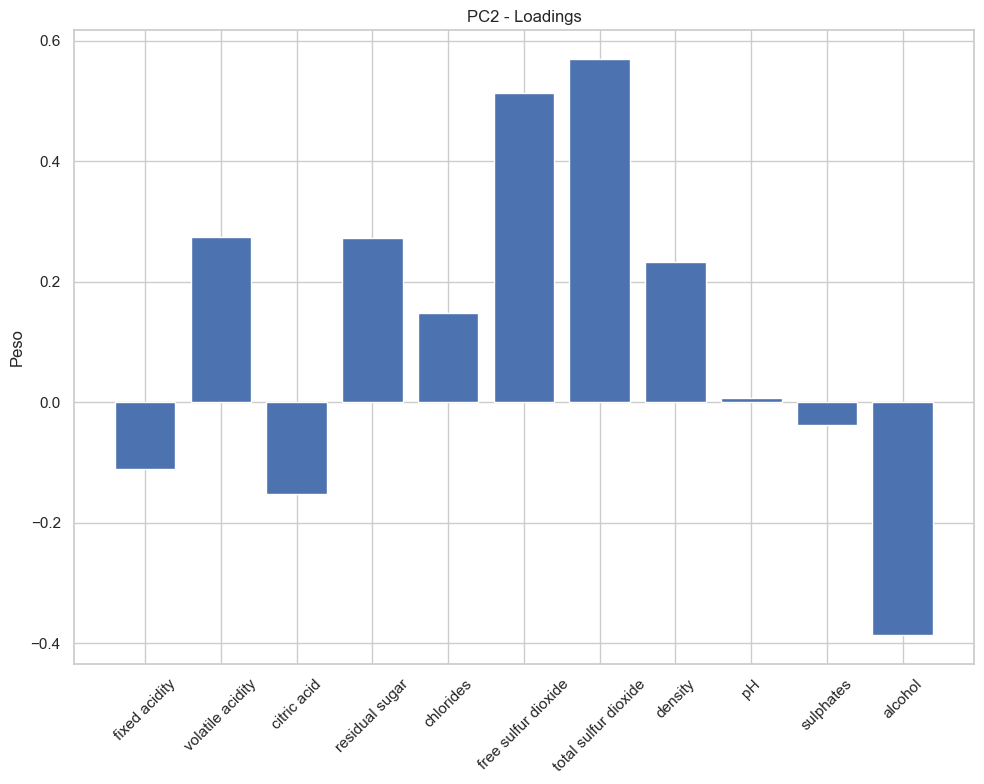

In [70]:
# Selezione delle feature numeriche, esclusi quality e quality_class
features = df_red.select_dtypes(include='number').drop(columns=['quality', 'quality_class'])
feature_names = features.columns.to_list()

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA per spiegare almeno il 97% della varianza (modifica se vuoi un altro valore)
pca_stand_m = PCA(0.97)
pca_stand_m.fit(X_scaled)

# Grafico dei loadings della PC1

plt.figure(figsize=(10, 8))
plt.bar(np.arange(len(feature_names)), pca_stand_m.components_[0, :])
plt.xticks(ticks=np.arange(len(feature_names)),
           labels=feature_names,
           rotation=45)
plt.title('PC1 - Loadings')
plt.ylabel('Peso')
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafico dei loadings della PC2

plt.figure(figsize=(10, 8))
plt.bar(np.arange(len(feature_names)), pca_stand_m.components_[1, :])
plt.xticks(ticks=np.arange(len(feature_names)),
           labels=feature_names,
           rotation=45)
plt.title('PC2 - Loadings')
plt.ylabel('Peso')
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
#FDA
fda = MDA(1)
fda.fit(X, y)
Zfda = fda.transform(X)
fig, axs = plt.subplots(figsize=(6, 3))
axs.scatter(Zfda, y, c=y, alpha=0.15)
axs.set_title('FDA')

NameError: name 'MDA' is not defined

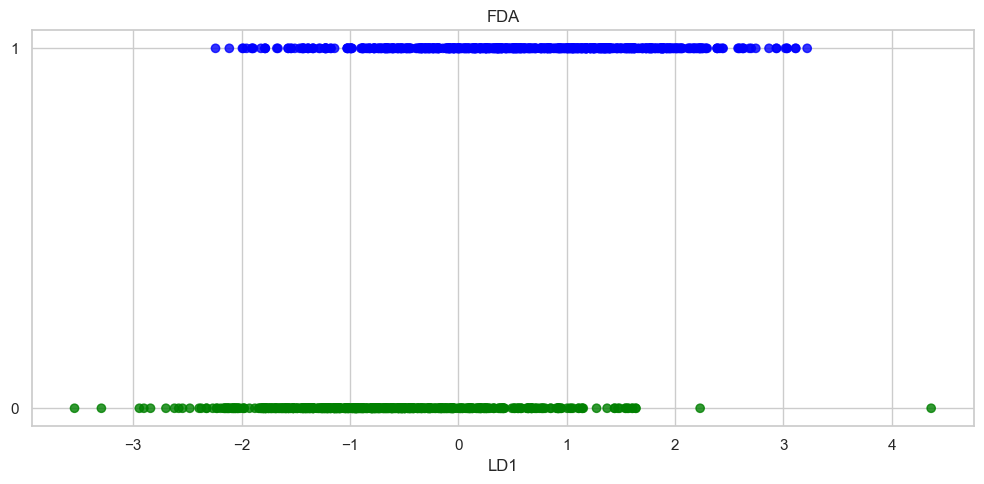

In [72]:
# 4. LDA con 1 componente (max per 2 classi)
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)

# 5. Preparazione per grafico
# Codifica classi come 0 e 1
y_codes = y_train.astype('category').cat.codes

# Colori personalizzati (puoi cambiarli)
colors = ['green', 'blue']
color_map = dict(zip(np.unique(y_codes), colors))
color_list = [color_map[i] for i in y_codes]

# 6. Plot orizzontale come nello screenshot
plt.figure(figsize=(10, 5))
plt.scatter(X_train_lda.flatten(), y_codes, c=color_list, alpha=0.8)
plt.yticks([0, 1], labels=sorted(y_train.unique()))
plt.xlabel('LD1')
plt.title('FDA')
plt.grid(True)
plt.tight_layout()
plt.show()